In [1]:
%matplotlib notebook
import os
from adm_library import *

In [5]:
fname = 'files/Cal 5DoF inputs 20230509.xlsx'
sheetname = 'Input for Tyler analysis'

adm_log_filepath = 'files/ADM Ops Log.xlsx'

spreadsheet = pd.read_excel(fname,
                            sheet_name=sheetname,skiprows=1,usecols='B:N')

focal_length = spreadsheet.iloc[0][0]-110 # focal length is track length -110mm, per TG
sMPA_to_WCS = spreadsheet.iloc[3,:3].astype(float)
sMPA_angle_to_WCS_deg = spreadsheet.iloc[6,:3].astype(float)
GSA_angle_WCS_deg = spreadsheet.iloc[7][0]
sMask=np.array(spreadsheet.iloc[10,1:4]).astype(float)

spreadsheet = pd.read_excel(fname,
                            sheet_name=sheetname,skiprows=15,usecols='B:N')
pose_actual = spreadsheet.iloc[0:5,0:6]
pose_actual = pose_actual.set_index('Name').sort_index()
pose_actual.columns = ['X','Y','Z','Rx','Ry']
X_5DOF,Y_5DOF,Z_5DOF,rx_deg_5DOF,ry_deg_5DOF = [[*pose_actual['X'].values.astype(float)],[*pose_actual['Y'].values.astype(float)],[*pose_actual['Z'].values.astype(float)],
                                                [*pose_actual['Rx'].values.astype(float)],[*pose_actual['Ry'].values.astype(float)]]


<IPython.core.display.Javascript object>


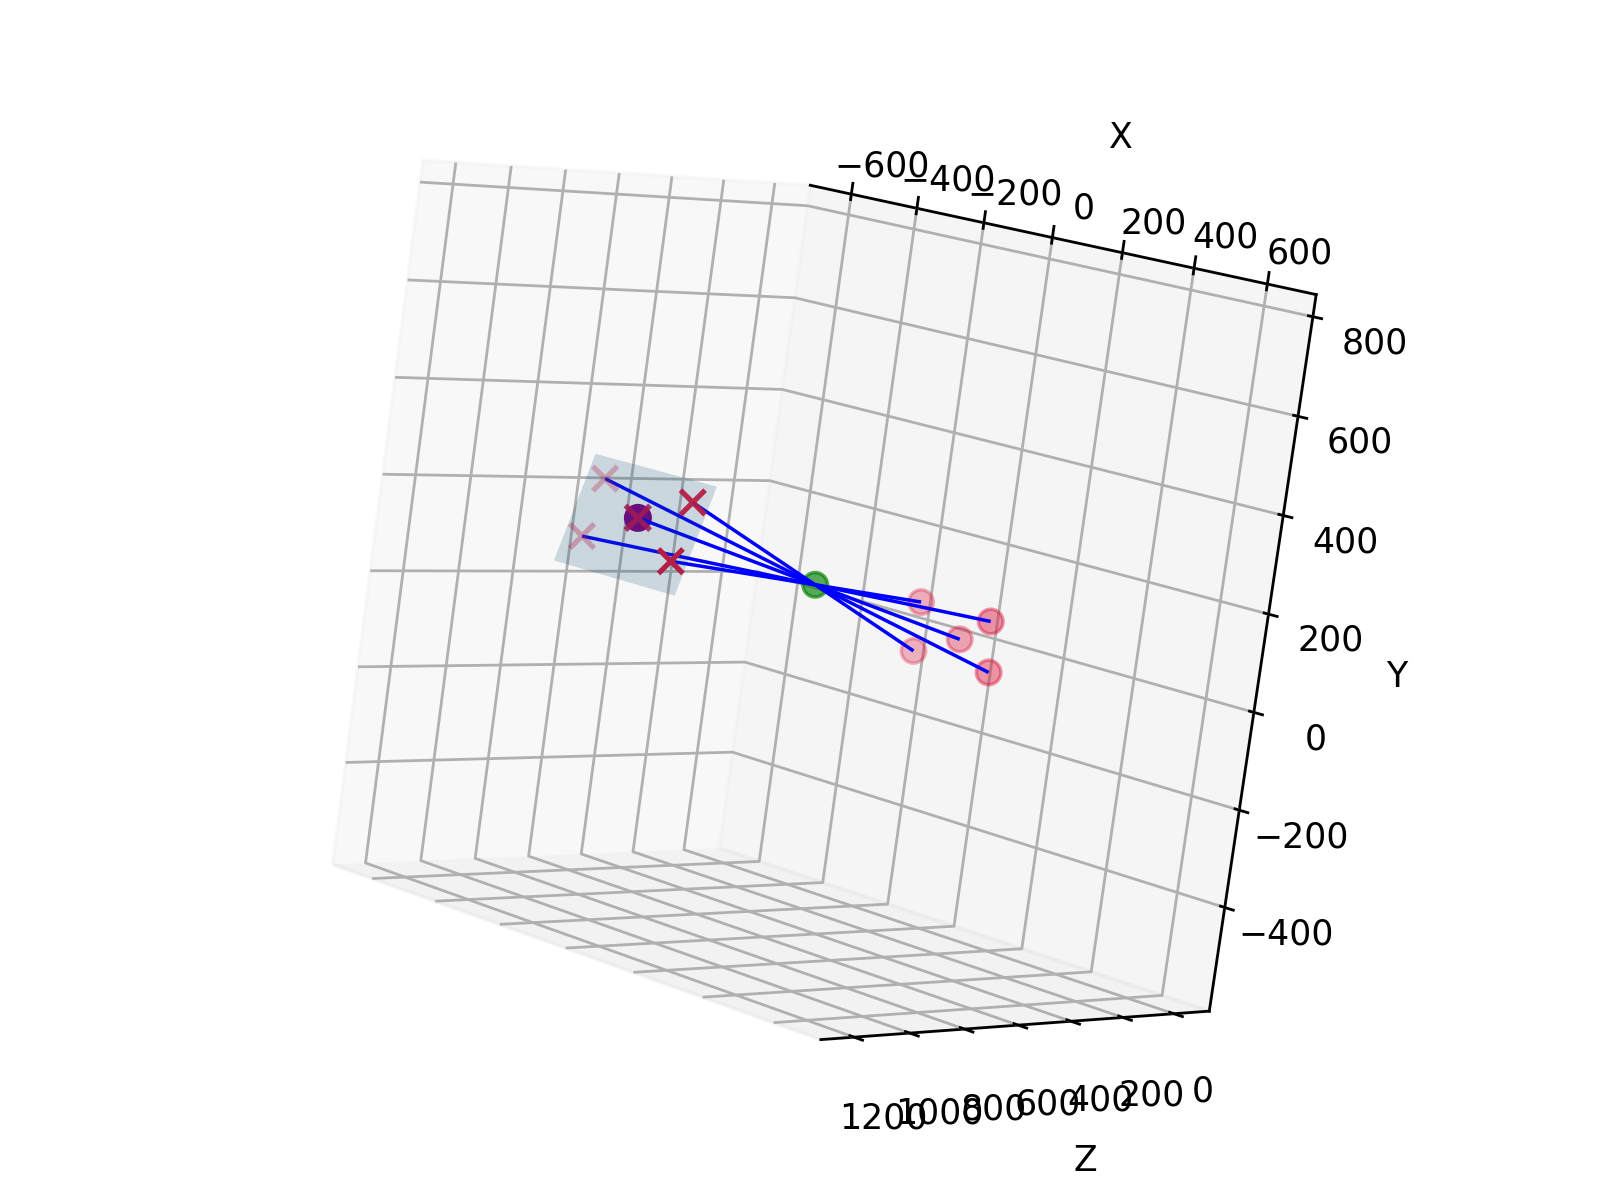

,X,Y,Z,Rx,Ry,color,uvec_X,uvec_Y,uvec_Z,Rz
Name,,,,,,,,,,
PR1,0.991107,0.115821,0.754433,0.021212,0.045726,crimson,1.031195,248.370010,1268.027256,NaN
PR2,-109.485707,-46.959858,23.47922,-4.915799,10.693732,crimson,239.765216,350.383100,1220.379520,NaN
PR3,111.329338,-46.602151,23.152164,-4.873486,-10.586882,crimson,-237.396982,349.604227,1221.065684,NaN
PR4,103.162412,58.543344,31.771468,5.291407,-10.304568,crimson,-231.135803,128.737997,1264.746858,NaN
PR5,-101.345145,58.305984,31.898431,5.265896,10.417492,crimson,233.640931,129.254531,1264.233772,NaN
sMask,1.469,115.184948,588.226533,NaN,NaN,g,NaN,NaN,NaN,NaN
sMPA,2.022,248.477,1268.761,-24.302000,0.043600,purple,0.000761,0.411546,0.911389,0.1048


In [6]:
#Generate a dataframe where we will store some parameters for each pose
columns = ['X','Y','Z','Rx','Ry']
df = pose_actual
df['color']='crimson'

gsa_rot = R.from_euler('x',GSA_angle_WCS_deg, degrees=True)
df.loc['sMask',['X','Y','Z']] = gsa_rot.apply(sMask)
df.loc['sMask','color'] = 'g'

df.loc['sMPA',['X','Y','Z']] = sMPA_to_WCS.values.astype(float)
df.loc['sMPA','color']='purple'

for pose in df.index:
    update_uvec(df,pose,length=focal_length,rotangle=GSA_angle_WCS_deg)
    if 'PDI' in pose:
        df.loc[pose,'color'] = 'yellow'

# create normal vector to sMPA
vec = np.array([0,0,1])
rotmat = R.from_euler('XYZ',sMPA_angle_to_WCS_deg, degrees=True)
df.loc['sMPA',['uvec_X','uvec_Y','uvec_Z']] = rotmat.apply(vec)

df.loc['sMPA',['Rx', 'Ry', 'Rz']] = sMPA_angle_to_WCS_deg.values.astype(float)

ax = plot_poses(df)
plot_sMPA(df, ax)
df

# Now point to an arbitrary location in the sMPA plane

In [11]:
coords = dict({'center':np.array([100.,0.,0.])})

location = 'center'

rotmat = R.from_euler('XYZ',df.loc['sMPA',['Rx','Ry','Rz']].values.astype(float), degrees=True)
center = df.loc['sMPA',['X','Y','Z']].values.astype(float)+rotmat.apply(coords[location])

center

array([ 102.02180377,  248.61238541, 1268.61637067])

# Compute the position of the projector that shoots that location through the sMask

In [12]:
uvec = df.loc['sMask',['X','Y','Z']].values.astype(float) - center
uvec /= np.linalg.norm(uvec)
df.loc[location,['X','Y','Z']] = center+uvec*focal_length
df.loc[location,['color']] = 'royalblue'
df.loc[location,['uvec_X','uvec_Y','uvec_Z']] = -uvec*focal_length

update_RxRy(df,location,GSA_angle_WCS_deg)


array([-0.1435233 , -0.19044666, -0.97114939])

In [40]:
def create_SORC_coords(df,fields):
    for field in fields.index:
        coords = fields.loc[field,['X','Y']].values.astype(float)
        coords = np.append(coords,[0.])
        rotmat = R.from_euler('XYZ',df.loc['sMPA',['Rx','Ry','Rz']].values.astype(float), degrees=True)
        center = df.loc['sMPA',['X','Y','Z']].values.astype(float)+rotmat.apply(coords)
        uvec = df.loc['sMask',['X','Y','Z']].values.astype(float) - center
        uvec /= np.linalg.norm(uvec)
        df.loc[field,['X','Y','Z']] = center+uvec*focal_length
        df.loc[field,['color']] = 'royalblue'
        df.loc[field,['uvec_X','uvec_Y','uvec_Z']] = -uvec*focal_length

        update_RxRy(df,field,GSA_angle_WCS_deg)


In [16]:
df

,X,Y,Z,Rx,Ry,color,uvec_X,uvec_Y,uvec_Z,Rz
Name,,,,,,,,,,
PR1,0.991107,0.115821,0.754433,0.021212,0.045726,crimson,1.031195,248.370010,1268.027256,NaN
PR2,-109.485707,-46.959858,23.47922,-4.915799,10.693732,crimson,239.765216,350.383100,1220.379520,NaN
PR3,111.329338,-46.602151,23.152164,-4.873486,-10.586882,crimson,-237.396982,349.604227,1221.065684,NaN
PR4,103.162412,58.543344,31.771468,5.291407,-10.304568,crimson,-231.135803,128.737997,1264.746858,NaN
PR5,-101.345145,58.305984,31.898431,5.265896,10.417492,crimson,233.640931,129.254531,1264.233772,NaN
sMask,1.469,115.184948,588.226533,NaN,NaN,g,NaN,NaN,NaN,NaN
sMPA,2.022,248.477,1268.761,-24.302000,0.043600,purple,0.000761,0.411546,0.911389,0.1048
center,-83.427951,2.531871,13.771912,0.008344,8.251776,royalblue,185.449755,246.080514,1254.844459,NaN


<IPython.core.display.Javascript object>


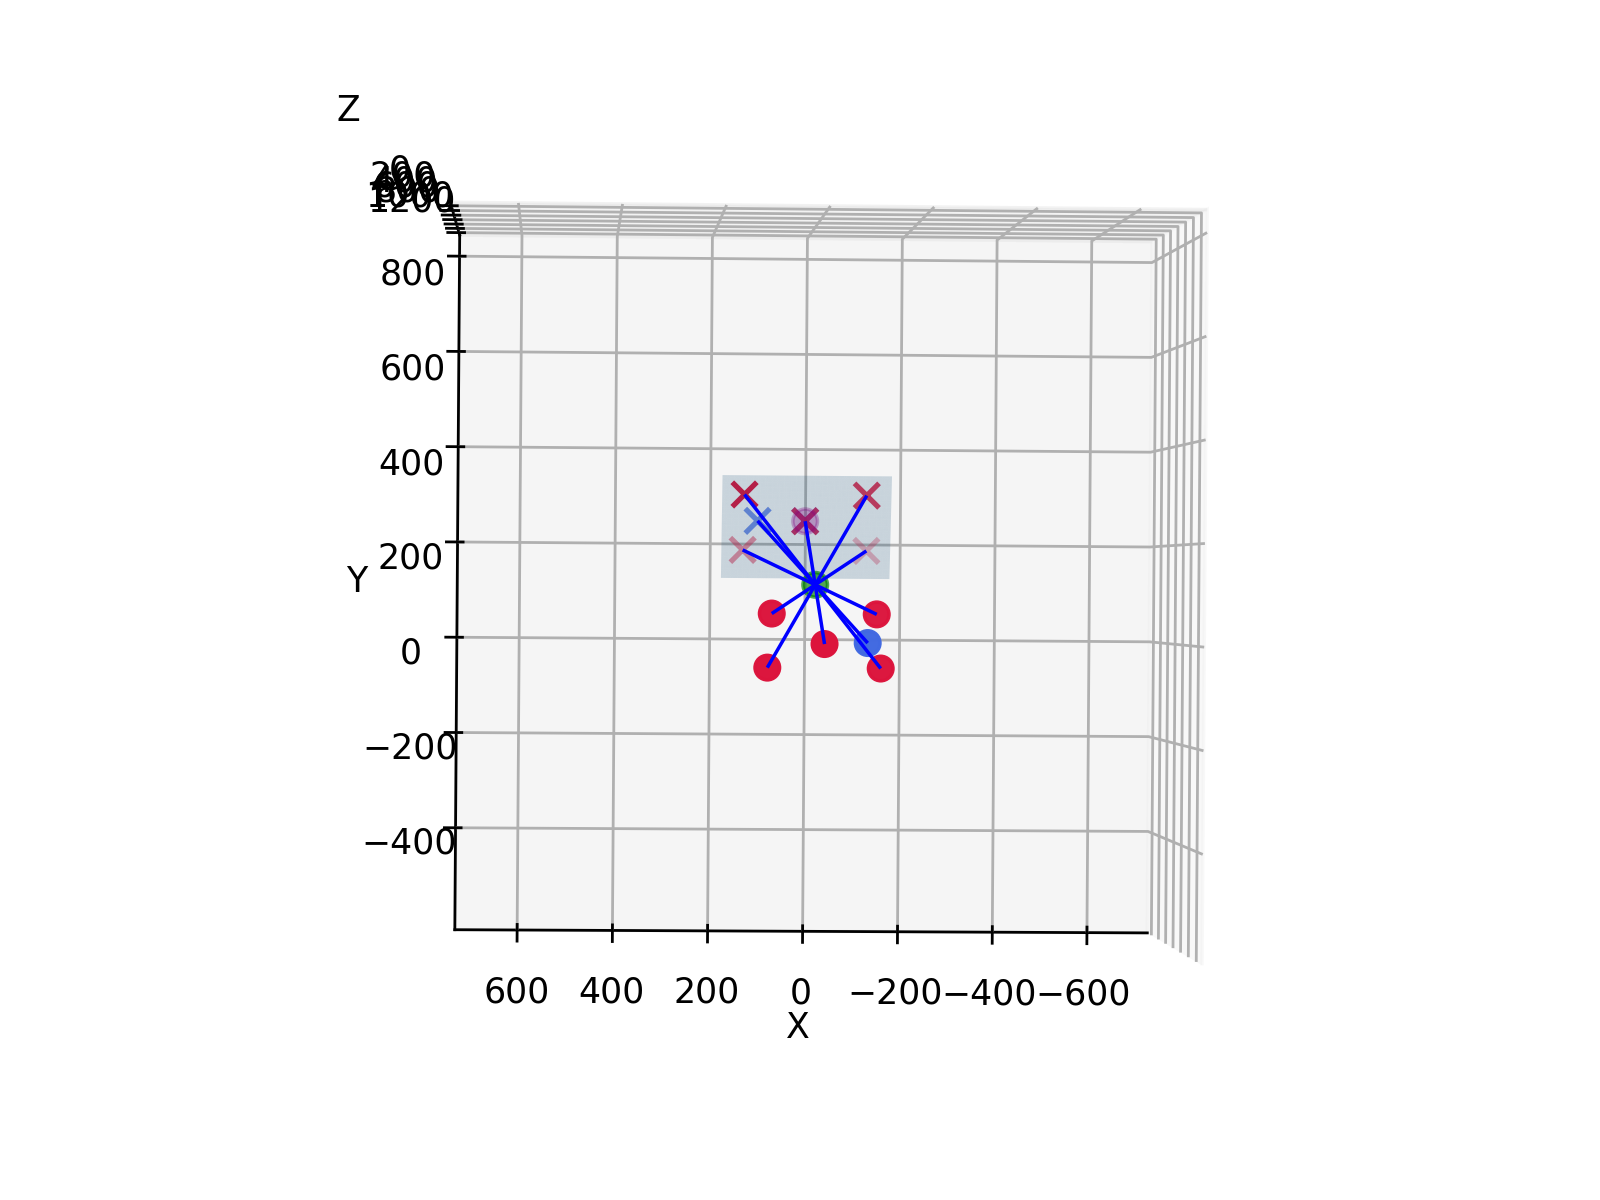

,X,Y,Z,Rx,Ry,color,uvec_X,uvec_Y,uvec_Z,Rz
Name,,,,,,,,,,
PR1,0.991107,0.115821,0.754433,0.021212,0.045726,crimson,1.031195,248.370010,1268.027256,NaN
PR2,-109.485707,-46.959858,23.47922,-4.915799,10.693732,crimson,239.765216,350.383100,1220.379520,NaN
PR3,111.329338,-46.602151,23.152164,-4.873486,-10.586882,crimson,-237.396982,349.604227,1221.065684,NaN
PR4,103.162412,58.543344,31.771468,5.291407,-10.304568,crimson,-231.135803,128.737997,1264.746858,NaN
PR5,-101.345145,58.305984,31.898431,5.265896,10.417492,crimson,233.640931,129.254531,1264.233772,NaN
sMask,1.469,115.184948,588.226533,NaN,NaN,g,NaN,NaN,NaN,NaN
sMPA,2.022,248.477,1268.761,-24.302000,0.043600,purple,0.000761,0.411546,0.911389,0.1048
center,-83.427951,2.531871,13.771912,0.008344,8.251776,royalblue,185.449755,246.080514,1254.844459,NaN


In [17]:
ax = plot_poses(df)
plot_sMPA(df, ax)
df

In [18]:
check_pupil_crossing([df])

        sMask to chief ray (mm)  sMask to origin (mm)
PR1                2.986135e-04            598.635616
PR2                2.329674e-04            597.947667
PR3                3.162577e-04            597.957692
PR4                3.660392e-04            568.499833
PR5                3.068644e-04            568.600846
sMask                       NaN              0.000000
sMPA               1.585905e+02            693.465383
center             2.580453e-14            591.520346


In [23]:
dat = pd.read_excel('/Users/mrizzo/Box Sync/WFI/I&T/TPT Input Information_v9.xlsx',sheet_name='Fields',skiprows=3,index_col='Name')
dat

,Unnamed: 0,Description,X,Y
Name,,,,
CenterField,"FDPR, Dispersion",As close as possible to field center,-4.00,0.000
SCA1,NaN,SCA center,-22.14,12.150
SCA2,NaN,SCA center,-22.29,-37.030
SCA3,NaN,SCA center,-22.44,-82.060
SCA4,NaN,SCA center,-66.42,20.900
SCA5,NaN,SCA center,-66.92,-28.280
SCA6,NaN,SCA center,-67.42,-73.060
SCA7,NaN,SCA center,-110.70,42.200
SCA8,NaN,SCA center,-111.48,-6.980


In [27]:
for location in dat.index:
    dat.loc[field,['X','Y']].values.astype(float)

[-4.  0.]
[-22.14  12.15]
[-22.29 -37.03]
[-22.44 -82.06]
[-66.42  20.9 ]
[-66.92 -28.28]
[-67.42 -73.06]
[-110.7   42.2]
[-111.48   -6.98]
[-112.64  -51.06]
[22.14 12.15]
[ 22.29 -37.03]
[ 22.44 -82.06]
[66.42 20.9 ]
[ 66.92 -28.28]
[ 67.42 -73.06]
[110.7  42.2]
[111.48  -6.98]
[112.64 -51.06]
[0. 0.]
[-21.78  -10.675]
[  0.  -33.9]
[  0.   -82.06]
[-75.  49.]
[-75.  -98.2]
[ -75. -104.]
[-67.33 -93.78]
[-67.33 -93.98]
[-67.33 -94.18]
[-140.  -52.]
[-92. -52.]
[-90. -50.]
[-106.31  -80.78]
[-107.02  -81.48]
[-95. -50.]
[-98. -50.]
[-130.14   61.64]
[-91.26  61.64]
[-132.08  -70.5 ]
[-86.86 -92.5 ]
[  -2.7 -101.5]
[ -41.88 -101.5 ]
[  41.88 -101.5 ]
[   2.7 -101.5]
[ 86.86 -92.5 ]
[132.08 -70.5 ]
[130.14  61.64]
[91.26 61.64]
[46.98 40.34]
[ 2.7  31.59]
[-2.7  31.59]
[-46.98  40.34]


In [41]:
create_SORC_coords(df,dat)
df

,X,Y,Z,Rx,Ry,color,uvec_X,uvec_Y,uvec_Z,Rz
Name,,,,,,,,,,
PR1,0.991107,0.115821,0.754433,0.021212,0.045726,crimson,1.031195,248.370010,1268.027256,NaN
PR2,-109.485707,-46.959858,23.47922,-4.915799,10.693732,crimson,239.765216,350.383100,1220.379520,NaN
PR3,111.329338,-46.602151,23.152164,-4.873486,-10.586882,crimson,-237.396982,349.604227,1221.065684,NaN
PR4,103.162412,58.543344,31.771468,5.291407,-10.304568,crimson,-231.135803,128.737997,1264.746858,NaN
PR5,-101.345145,58.305984,31.898431,5.265896,10.417492,crimson,233.640931,129.254531,1264.233772,NaN
sMask,1.469,115.184948,588.226533,NaN,NaN,g,NaN,NaN,NaN,NaN
sMPA,2.022,248.477,1268.761,-24.302000,0.043600,purple,0.000761,0.411546,0.911389,0.1048
center,-83.427951,2.531871,13.771912,0.008344,8.251776,royalblue,185.449755,246.080514,1254.844459,NaN
CenterField,4.444613,0.125367,0.750715,0.022152,-0.284795,royalblue,-6.422605,248.346218,1268.016070,NaN


<IPython.core.display.Javascript object>


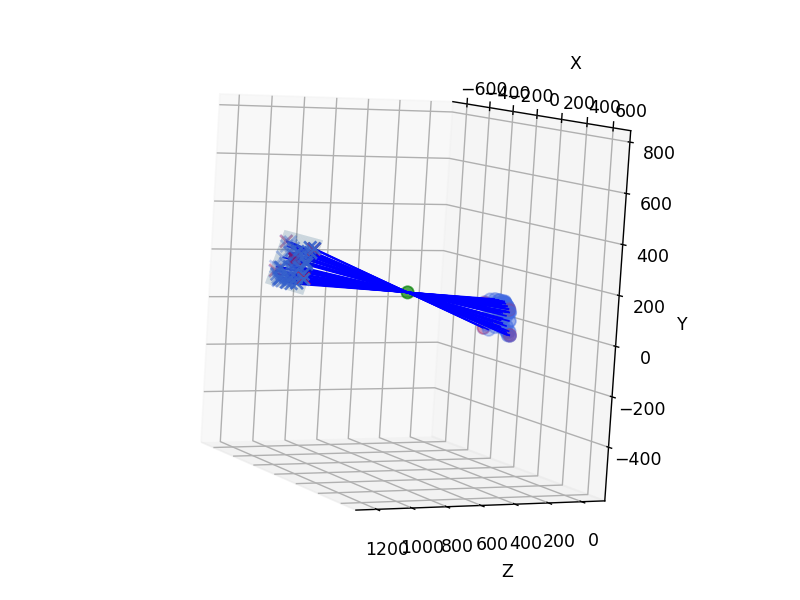

,X,Y,Z,Rx,Ry,color,uvec_X,uvec_Y,uvec_Z,Rz
Name,,,,,,,,,,
PR1,0.991107,0.115821,0.754433,0.021212,0.045726,crimson,1.031195,248.370010,1268.027256,NaN
PR2,-109.485707,-46.959858,23.47922,-4.915799,10.693732,crimson,239.765216,350.383100,1220.379520,NaN
PR3,111.329338,-46.602151,23.152164,-4.873486,-10.586882,crimson,-237.396982,349.604227,1221.065684,NaN
PR4,103.162412,58.543344,31.771468,5.291407,-10.304568,crimson,-231.135803,128.737997,1264.746858,NaN
PR5,-101.345145,58.305984,31.898431,5.265896,10.417492,crimson,233.640931,129.254531,1264.233772,NaN
sMask,1.469,115.184948,588.226533,NaN,NaN,g,NaN,NaN,NaN,NaN
sMPA,2.022,248.477,1268.761,-24.302000,0.043600,purple,0.000761,0.411546,0.911389,0.1048
center,-83.427951,2.531871,13.771912,0.008344,8.251776,royalblue,185.449755,246.080514,1254.844459,NaN
CenterField,4.444613,0.125367,0.750715,0.022152,-0.284795,royalblue,-6.422605,248.346218,1268.016070,NaN


In [42]:
ax = plot_poses(df)
plot_sMPA(df, ax)
df

In [48]:
df_encoder_space = pd.DataFrame(columns=['X', 'Y', 'Z', 'Rx', 'Ry'])
for pose in df.index:
    df_encoder_space = pd.concat([df_encoder_space,calculate_encoders_from_5DOF(pd.DataFrame(df.loc[pose]).T)])

df_encoder_space

,X,Y,Z,Rx,Ry
PR1,0.968110,0.149959,0.739956,0.021941,0.047806
PR2,-109.388136,-47.030270,23.376694,-4.915767,10.692735
PR3,111.283617,-46.304538,23.248360,-4.872000,-10.586625
PR4,102.971310,58.768453,31.962197,5.296265,-10.302126
PR5,-101.400777,58.164365,31.901152,5.265307,10.418327
sMask,NaN,NaN,NaN,NaN,NaN
sMPA,4584.702534,-14968.000998,8292.768964,-24.535917,-0.026506
center,-83.407012,2.407195,13.737918,0.008965,8.252468
CenterField,4.420049,0.165764,0.739493,0.022899,-0.282702
SCA1,20.242596,-10.252600,0.805087,-0.955457,-1.789634


In [49]:
df_encoder_space.to_excel('/Users/mrizzo/Box Sync/WFI/I&T/fields_encoders.xlsx')